# Modèles linèaires d'apprentissage statistique pour la classification des génomes de virus

**Amine Remita**

## Plan
1. Introduction
2. Données génomiques et leurs representations
3. Modèles de classification
  1. Modèles génératifs
  2. Modèles discriminatifs


# 1. Introduction

La classification des séquences nucléotidiques est la tache d'assigner une nouvelles séquence ou une séquence inconnue à un groupe de séquences connues en se basant sur leures caractéristiques. La classification des séquences génomiques des virus est une tache importante dans la détection des pathogènes, la classification taxonomique, l'identification des réseaux de transmission et dans les études épidéiologiques et évolutives des virus.  
Il existe plusieurs approches pour classifier les séquences virales. Ici, on explore une approche qui utilise des séquences non alignées représentées par des vecteurs de *k*-mers. Ces vecteurs seront exploités par des modèles linéaires d'apprentissage statique.  

Le but de la classification d'un objet (une séquence représenté par un vecteur de *k*-mers $\textbf{x}$ ici) est de calculer les probabilités d'appartenance de la séquence à toutes les classes du jeu de données $P(C\,|\,\textbf{x})$ (probabilité conditionnelle de la classe étant donné la séquence $\textbf{x}$). Une fois qu'on obtient cette densité, $x$ est assigné à la classe qui a la $P(C\,|\,\textbf{x})$ la plus élevée. On peut noter ça par :

$$\hat{C} = argmax_{c} P(C_c\,|\,\textbf{x}).$$

D'abord, on doit savoir comment représenter et calculer les différentes entitées $\textbf{x}$ et $C$ pour qu'on puisse les utiliser dans des modèles de classification.

# 2. Données génomiques et leurs représentations

In [1]:
# Fichier FASTA contenant les séquences biologiques (nucléotidiques dans notre cas)
seq_file = "../data/viruses/HIV03/data.fa"

!head -n 10 $seq_file

>HQ995486 HIV1_D
CCTCAAATCACTCTTTGGCAACGACCCCTCGTCACAATAAGGATAGGGGGACAGCTAAAG
GAAGCTCTATTAGACACAGGAGCAGATGATACAGTATTAGAAGAAATGAATTTGCCAGGA
AAATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGAT
CAAATACTAGTAGAAATCTGTGGACATAAAGCTATAGGTACAGTGTTAGTAGGACCTACA
CCTGTCAACATAATTGGAAGAAATTTGTTGACTCAGATTGGCTGTACTTTAAATTCCAAT
TAGTCCTATTGAAACTGTACCAGTRAAATTAAAGCCMGGGATGGATGGCCCAAGAGTTAG
ACAATGGCCGCTGACRGAAGAAAAAATAAAAGCACTAACAGAAATTTGTACAGAGTTAGA
AAAGGAAGGAAAAATTTCAAGARTCGGGCCTGAAAATCCATACAATACCCCAATATTTGC
CATAAAKAAAAAAGACAGTACTAAGTGGAGAAAATTAGTAGATTTTAGAGAACTTAATAA


In [2]:
# Fichier d'annotation contenant les classes (soust-types dans notre cas) de chaque séquence du fichier FASTA précedent
cls_file = "../data/viruses/HIV03/class.csv"

!head -n 10 $cls_file

AB078678,HIV1_08_BC
AB078681,HIV1_07_BC
AB078698,HIV1_08_BC
AB253660,HIV1_01_AE
AB253697,HIV1_01_AE
AB356197,HIV1_D
AB442313,HIV1_B
AB640150,HIV1_01_AE
AB640306,HIV1_B
AB640429,HIV1_A


In [3]:
from slm_kgenomvir.bio import seq_collections

all_seqs = seq_collections.SeqCollection((seq_file, cls_file))

# Extraire les séquences HIV pures :
list_pures = ['HIV1_A', 'HIV1_B', 'HIV1_C', 'HIV1_D', 'HIV1_F', 'HIV1_G', 'HIV1_H']
seq_pures = seq_collections.SeqCollection([ seq for seq in all_seqs if seq.label in list_pures ])

print("Nombre de séquences par classes :\n{}".format(seq_pures.get_count_labels()))
print("\nNombre total de séquences: {}".format(len(seq_pures)))

Nombre de séquences par classes :
{'HIV1_D': 50, 'HIV1_F': 50, 'HIV1_A': 50, 'HIV1_G': 50, 'HIV1_C': 50, 'HIV1_H': 50, 'HIV1_B': 50}

Nombre total de séquences: 350


In [4]:
# Calcule des attributs basés sur les k-mers
from slm_kgenomvir.bio import kmer_collections as kmers

k_len = 2 # Taille des k-mers à extraire

seq_kmers = kmers.build_kmers(seq_pures, k_len, full_kmers=False, sparse=None)

seq_X = seq_kmers.data
seq_y = np.asarray(seq_pures.labels)

assert seq_X.shape[0] == len(seq_pures)

list_kmers = seq_kmers.kmers_list
feat_size = seq_X.shape[1] # nombre d'attribut (ou la taille du vocabulaire)

print("List des k-mers (attributs):\n{}".format(list_kmers))
print("Nombre des k-mers: {}".format(feat_size))

List des k-mers (attributs):
['CC', 'CT', 'TC', 'CA', 'AA', 'AT', 'AC', 'TT', 'TG', 'GG', 'GC', 'CG', 'GA', 'GT', 'TA', 'AG']
Nombre des k-mers: 16


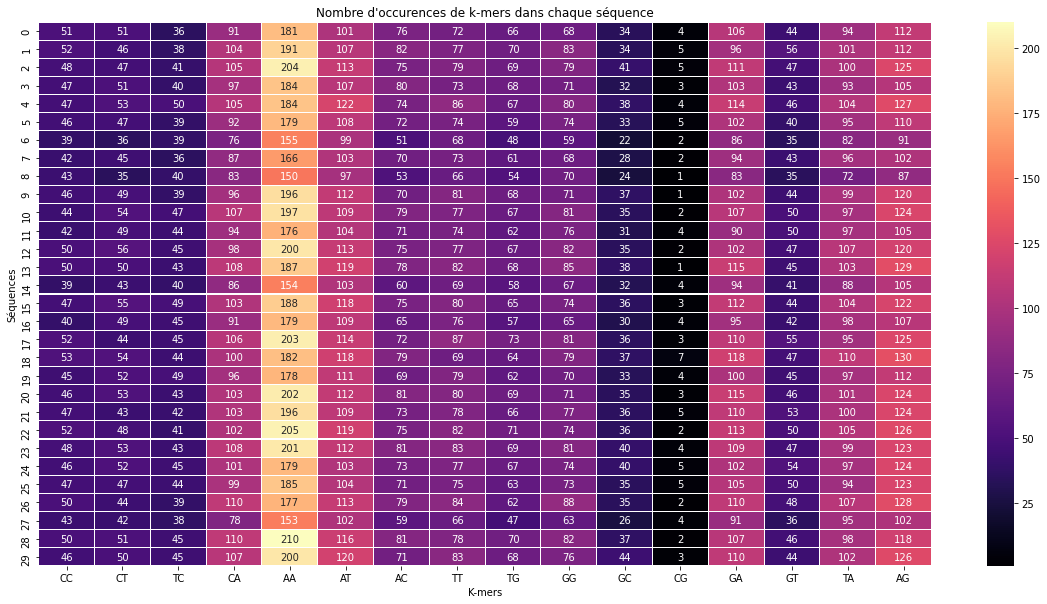

In [5]:
#  Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(seq_X[:30], cmap="magma", annot=True, fmt=".0f", linewidth=0.1, xticklabels=list_kmers)

plt.title("Nombre d'occurences de k-mers dans chaque séquence")
plt.xlabel("K-mers")
plt.ylabel("Séquences")
plt.show()

In [6]:
## Creation de jeux d'entrainement et de test

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
rs = 42
test_size = 0.3

# X_train, X_test, y_train, y_test = train_test_split(seq_X, seq_y, 
#                                                     test_size=test_size, 
#                                                     shuffle=True, 
#                                                     random_state=rs)

sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
train_index, test_index = next(sss.split(seq_X, seq_y))

X_train = seq_X[train_index]
y_train = seq_y[train_index]
X_test = seq_X[test_index]
y_test = seq_y[test_index]

# Vérifier que le jeu de test contient toutes les classes dans le jeu d'entrainement. 
assert np.all(np.unique(y_train) == np.unique(y_test)) 

print(X_train.shape)
print(y_train.shape)

(245, 16)
(245,)


# 3. Modèles de classification

Comme il est montioné dans l'introdution, le but de la classification d'une séquence $\textbf{x}$ est d'estimer la densité $P(C\,|\,\textbf{x})$ et de l'assigner à la classe qui a la probabilité la plus élevée. Généralement on utilise l'échelle logarithmique ($\log$) quand on travaille avec les probabilités. C'est plus stable numériquement quand les probabilités tendent vers le zéro et on transforme les multiplications des probabilités en additions de logarithmes de probabilités. Aussi la fonction $\log$ est une fonction monotone croissante, donc : $\hat{C}= argmax_{c} \log P(C_c\,|\,\textbf{x}).$

Un algorithme de classification contient deux étapes:
1. **Entrainement du modèle**: estimation des paramètres du modèles à partir d'un jeu de données
2. **Prédiction**: utilisation des paramètres estimés pour prédire les classes d'un jeu de données non observé durant l'entrainement.


On peut catégoriser les modèles d'apprentissage statistiques en deux classes selon la méthodes qu'ils calculent la densité $P(C\,|\,\textbf{x})$ :

1. **Modèles génératifs** : estiment la densité cojointe de la classe et de la séquence $P(C\,,\,\textbf{x})$.

2. **Modèles discriminatifs** : estiment directement la densité a posteriori $P(C\,|\,\textbf{x})$.


## 3.1. Modèles génératifs

Un modèle génératif estime la densité cojointe de la classe et de la séquence $P(C\,,\,\textbf{x})$ et utilise le théorème de **Bayes** pour calculer la probabilité conditionnelle (*a posteriori*) $P(C\,|\,\textbf{x})$. 

$$ P(C\,|\,\textbf{x}) = \frac{P(C\,,\,\textbf{x})}{P(\textbf{x})} = \frac{P(\textbf{x}\,|\,C)\,P(C)}{\sum_{c}P(\textbf{x}\,|\,C_c)\,P(C_c)}.$$ 

On appelle les différentes probabilités (densités) :

* $P(C)$: la probabilité *a priori* de la classe
* $P(\textbf{x}\,|\,C)$: le likelihhod
* $P(\textbf{x})$: l'évidence ou le likelihood marginalisé (parce que $P(\textbf{x}) = \sum_{c}P(\textbf{x}\,|\,C_c)\,P(C_c)$).


Les modèles génératifs différent par l'approche utilisée pour estimer **la densité *a priori* $P(C)$** et principalement **le likelihood $P(\textbf{x}\,|\,C)$**.


### 3.1.1. Estimation de la densité *a priori*
Étant donné un ensemble de séquences de nombre total $N$ étiquettés par $M$ classes (sous-types), et chaque classe $C$ a une taille $N_c$ (ça veut dire qu'il y a $N_c$ séquences sous-typées $C$). La densité *a priori* des classes $P(C)$ peut être estimée par :

* Distribution uniforme sur le nombre de classe : $P(C_c) = 1\: /\: M$ (probabilité identique pour chaque classe).
* Une approche Maximum Likelihood Estimation (MLE) : $P(C_c) = N_c \:/\: N$
* Une approche Bayesienne : $P(C_c) = N_c+\alpha\:/\: N+ M\alpha $. ($\alpha >0$ est un pseudocount)


### 3.1.2. Modèle Bayesien Multinomial
Le modèle Bayesien multionaomial utilise une distribution multinomiale pour modéliser le likelihood $P(x\,|\,C)$ avec une fonction de masse :

$$P(\textbf{x}\,|\,C_c) = \frac{d\,!}{\prod_{i=1}^{m} x_i\,!} \prod_{i=1}^{m}P(u_i\,|\,C_c)^{x_i}. $$

où $d$ est le nombre total de k-mers dans une séquence $\textbf{x}$, $m$ Le nombre de k-mers uniques dans le jeu de données. $u_i$ est un k-mer qui a un nombre d'occurence (fréquence) $x_i$. ${P(u_i\,|\,C_c)}$ est la probabilité conditonnelle du k-mer $u_i$ dans la classe $C_c$. Les densités ${P(u_i\,|\,C)}$ pour chaque k-mer $u_i$ peuvent être calculées par une 

* Approche MLE : ${P(u_i\,|\,C)} = \frac{N_{ci}}{N_c}$
* Approche Bayesienne : ${P(u_i\,|\,C)} = \frac{N_{ci} + \alpha}{N_c + m \alpha}$

où $N_{ci}$ est le nombre d'occurence du k-mer $u_i$ dans la classe $C_c$, $N_c$ est la taille de la classe $C_c$ et $\alpha >0 $ est un pseudocount (smoothing).

L'ensemble des densités $P(C)$ et ${P(u_i\,|\,C)}$ constituent les **paramètres du modèle**. Ça veut dire, dans l'étape de l'entrainement, seulement ces entités qui doivent être estimées à partir d'un jeu de données.


<ins>Remarque 1</ins> : l'utilisation de l'échelle logarithmique remplace les multiplications dans la fonction de masse par une sommation.  

<ins>Remarque 2</ins> : généralement dans un modèle Naive Bayes multinomial, le premier terme multiplicatif $\frac{d\,!}{\prod_{i=1}^{m} x_i\,!}$ est omis parce qu'il ne dépend pas des probabilités des k-mers ${P(u_i\,|\,C)}$ donc il n'affacte pas le résultat d'$argmax$ sur les probabilités *a posteriori* $P(C\,|\,\textbf{x})$. Par contre, si on veut estimer correctement ces densités c'est mieux de le calculer (même que son logarithme est difficile à calculer parce que il inclut des termes factoriels).


#### A. Entrainement du modèle

##### Estimation des probabilités a priori des classes P(C)
Distribution uniforme sur le nombre de classe : $\log P(C_c) = \log (1\: /\: M)$

In [7]:
# Estimation des probabilités a priori des classes log P(C) (variable log_class_priors)

# Liste des classes (uniques)
classes, class_counts = np.unique(y_train, return_counts=True)

# Nombre de classes (uniques)
n_classes = len(classes)

print("Nombre de classes: {}\n".format(n_classes))
print("List des classes: {}\n".format(classes))
print("Nombre d'instances par classes: {}\n".format(class_counts))

# Distribution uniforme
class_priors = np.full(n_classes, 1/n_classes)

# Distribution empirique (MLE)
# class_priors = class_counts / class_counts.sum()

# En log
log_class_priors = np.log(class_priors)
print("Log des probabilités a priori des classes:\n{}\n".format(log_class_priors))

Nombre de classes: 7

List des classes: ['HIV1_A' 'HIV1_B' 'HIV1_C' 'HIV1_D' 'HIV1_F' 'HIV1_G' 'HIV1_H']

Nombre d'instances par classes: [35 35 35 35 35 35 35]

Log des probabilités a priori des classes:
[-1.94591015 -1.94591015 -1.94591015 -1.94591015 -1.94591015 -1.94591015
 -1.94591015]



##### Estimation des probabilités conditonnelles des k-mers $P(u_i | C)$
On utilise une approche Bayesienne pour estimer : $\log {P(u_i\,|\,C)} = \log \left [ \frac{N_{ci} + \alpha}{N_c + m \alpha} \right]$

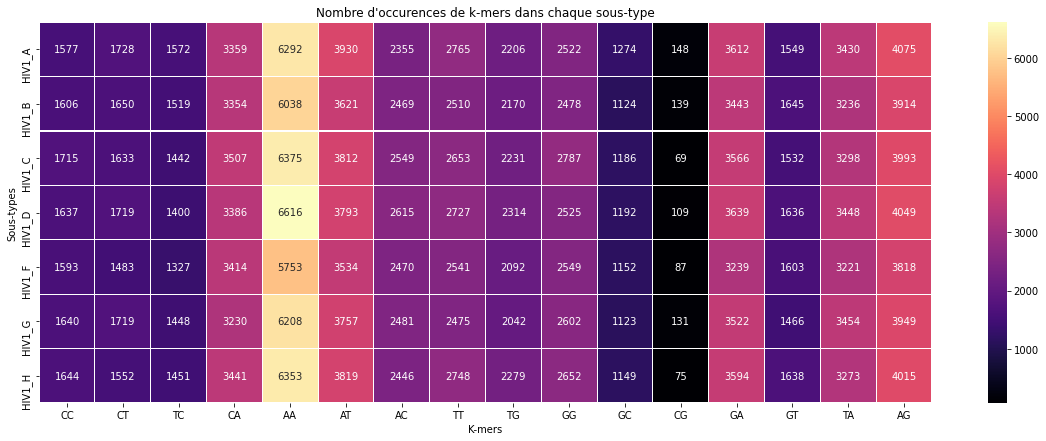

In [8]:
# Estimation des probabilités conditonnelles des k-mers P(u_i | C)

# Calcule de N_ci : nombre d'occurence de chaque k-mer $u_i$ dans chaque classe $C_c$
count_per_class = np.zeros((n_classes, feat_size))

for ind in range(n_classes):
     # Je cherche toutes les instances X classées par classes[ind]
    X_class = X_train[y_train == classes[ind]]
    # Je somme le nombre de kmers 
    count_per_class[ind, :] = np.sum(X_class, axis=0)

#  Visualisation
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(count_per_class, cmap="magma", annot=True, fmt=".0f", linewidth=0.1, 
            xticklabels=list_kmers, yticklabels=classes)

plt.title("Nombre d'occurences de k-mers dans chaque sous-type")
plt.xlabel("K-mers")
plt.ylabel("Sous-types")
plt.show()

In [9]:
 alpha = 1e-5 # hyper=prametre

# Calcule N_ci + alpha (variable beta)
beta = count_per_class + alpha

# Calcul N_c + m*alpha (variable beta_sum)
beta_sum = beta.sum(axis=1)

Finalement, estimation de log $P(u_i\,|\,C)$
$$
\begin{aligned}
\log {P(u_i\,|\,C)} &= \log \left[ \frac{N_{ci} + \alpha}{N_c + m \alpha} \right]\\ 
&= \log (N_{ci} + \alpha) - \log (N_c + m \alpha)
\end{aligned}
$$

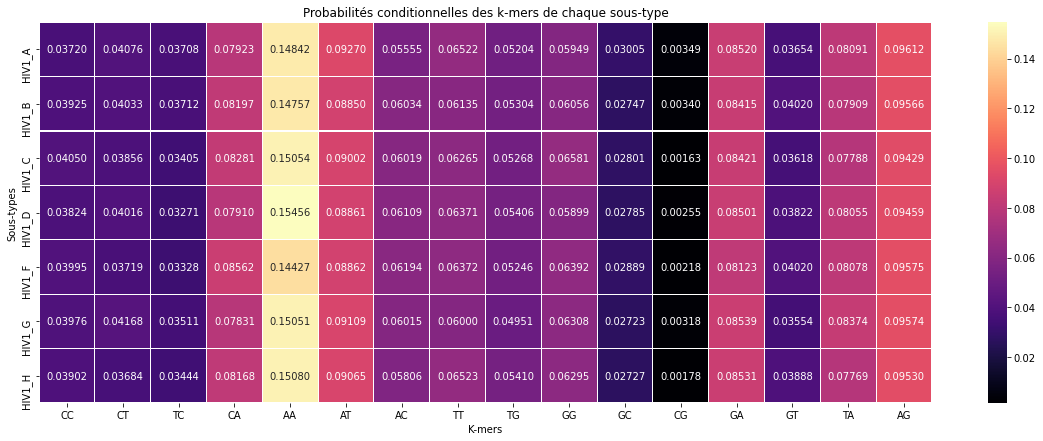

In [10]:
# Finalement, calcul de log P(u_i | C) (variable kmer_log_probs)

# Méhode 1 : Avec une boucle python
# kmer_log_probs = np.zeros((n_classes, feat_size))
# for ind in range(n_classes):
#     kmer_log_probs[ind] = np.log(beta[ind]) - np.log(beta_sum[ind])

# Méthode 2 : Avec vectorisation:
kmer_log_probs = np.log(beta) - np.log(beta_sum.reshape(-1, 1))

# print(kmer_log_probs.shape)

#  Visualisation
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(np.exp(kmer_log_probs), cmap="magma", annot=True, fmt=".5f", linewidth=0.1, 
            xticklabels=list_kmers, yticklabels=classes)

plt.title("Probabilités conditionnelles des k-mers de chaque sous-type")
plt.xlabel("K-mers")
plt.ylabel("Sous-types")
plt.show()

#### B. Prediction

Pour prédire le sous-type (classe) d'une nouvelle séquence $\textbf{x}$ avec un modèle Bayesien multinomial

$$
\begin{aligned}
\hat{C} &= argmax_{c} P(C_c\,|\,\textbf{x}) \\
  &= argmax_{c} \log P(C_c) + \sum_{i=1}^{m} x_i \log P(u_i\,|\,C_c)
\end{aligned}
$$

In [11]:
# Calcule du log de la probabilité cojointe P(X, C)
from scipy.special import logsumexp, gammaln

log_cte_norm_test = gammaln(X_test.sum(axis=1) + 1) - gammaln(X_test+1).sum(axis=1)
log_dot_prob_test = np.dot(X_test, kmer_log_probs.T)

ljb_test = log_dot_prob_test + log_cte_norm_test.reshape(1, -1).T + log_class_priors

In [12]:
# Predire la classe
y_pred = classes[np.argmax(ljb_test, axis=1)]

In [13]:
# Predire la probabilité d'appartenance P(C|x) = P(x, C) / P(x)

# log P(x)
log_prob_x = logsumexp(ljb_test, axis=1)

# log P(C | x)
log_prob_c_x = ljb_test - np.atleast_2d(log_prob_x).T

# P(C | x)
prob_c_x = np.exp(log_prob_c_x)

In [14]:
# Calculer des mesures de performances
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      HIV1_A       0.53      0.67      0.59        15
      HIV1_B       0.60      0.60      0.60        15
      HIV1_C       0.67      0.80      0.73        15
      HIV1_D       0.88      0.47      0.61        15
      HIV1_F       0.81      0.87      0.84        15
      HIV1_G       0.67      0.53      0.59        15
      HIV1_H       0.65      0.73      0.69        15

    accuracy                           0.67       105
   macro avg       0.68      0.67      0.66       105
weighted avg       0.68      0.67      0.66       105



### 3.1.3. Modèle basé sur les chaines de Markov

$$
\begin{aligned}
P(S\,|\,C_c) &= \prod_{i=k}^{l} P(s_i\,|\,S_{[i-k-1,\,i-1]},\,C_c)\\
             &= \prod_{i=k}^{l} \frac{P(u^{i-k-1}\,|\,C_c)}{P(v^{i-k-1}\,|\,C_c)},
\end{aligned}
$$

### 3.1.4. Exemples de modèles génératifs 

| Outil | Type de modèle                   | Utilisation     | Article                                       |
|:------|:---------------------------------|:----------------|:----------------------------------------------|
|RDP    | Naive Bayes Bernoulli            |Métagénomique |https://aem.asm.org/content/73/16/5261            |
|NBC    | MLE Naive Bayes Multinomial      |Métagénomique |https://www.hindawi.com/journals/abi/2008/205969/ |
|-      | Naive Bayes Multinomial Bayesien |Métagénomique |https://ieeexplore.ieee.org/document/6604390      |
|COMET  | Chaines de Markov avec ordres variables|Viral |https://academic.oup.com/nar/article/42/18/e144/2434545 |

## 3.2. Modèles discriminatifs

Un modèle discriminatif estime directement la densité a posteriori $P(C\,|\,x)$ sans assumer aucune distibution $P(x\,|\,C)$ sur les données. Ces modèles peuvent utiliser différentes stratégies pour aboutir à cette densité. Parmi ces modèles, on a la regression logistiques et les suport vector machine (SVM).


### 3.2.1. Régression Logistique Multinomiale (RLM)

RLM modélise la probabilité a posteriori $P(C_c\,|\,\textbf{x})$ avec la fonction softmax qui a la forme :


$$P(C_c\,|\,\textbf{x}; \textbf{W},  b) = \frac{\exp(\textbf{w}_c^\intercal\textbf{x} + b_{c})} {\sum_{l=1}^{M} \exp(\textbf{w}_l^\intercal\textbf{x} + b_{l})}$$

où $\textbf{W} = (\textbf{w}_1, \textbf{w}_2, ..., \textbf{w}_M)$ est une matrice $m \times M$ de poids et $b$ est le vecteur de $M$ intercepts. Donc, un modèle RLM est défini par l'ensemble de paramètres $\theta = (\textbf{W}, b)$. 

In [15]:
# Calculer les probabilités conditionnelles avec la fonction softmax
# source mlxtend
def calculer_softmax(x, W, b):
    z = x.dot(W) + b
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

Afin de trouver les paramètres $\textbf{W}$ et $b$ optimaux (qui maximisent la bonne classification), le modèle a besoin d'une mesure de distance entre sa classification actuelle $\hat{C}$ et la vraie classification $C$ des exemples. Dans le cas de RLM, cette mesure de distance est la **fonction de perte d'entropie croisée** (Cross Entropy loss function). La fonction d'entropie croisée correspond au négatif du logarithme du likelihood de toutes les données (voir le chapitre 4.3.4 du livre Bishop (2006)) et elle a la forme :

$$
L(x_i, C, \theta) = -\, \frac{1}{N} \sum_{n=1}^{N} \sum_{c=1}^{M} C_{kn} \log P(C_{c}\,|\,\textbf{x}_n; \theta)
$$


In [16]:
# Fonction de perte
# source mlxtend
def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target), axis=1)

Ici on encode la vrai classe $C_{cn}$ d'un exemple $x_n$ avec un vecteur binaire de taille $M$ où toutes ses valeurs égalent à zéro sauf la $c^{\textrm{ème}}$ valeur égale à 1. On applle cet encodage **One-hot** ou **One-of-K**.

In [17]:
# Encodage des classes
from sklearn.preprocessing import LabelBinarizer
y_encoder = LabelBinarizer()

y_train_enc = y_encoder.fit_transform(y_train).astype(np.long, copy=False)
y_test_enc = y_encoder.transform(y_test).astype(np.long, copy=False)

Il y a plusieurs approches pour chercher les valeurs optimales des paramètres $\theta$ d'un modèle d'apprentissage statistique étant donné un jeu de données. RLM *fite* ses paramètres $\theta$ en minimisant une fonction de coût composée de sa fonction de perte (Cross entropy) et d'une fonction de régularization $R$ :

$$
    \min_{\theta} 
    \left[- \frac{1}{N} 
    \sum_N \sum_M\,
    C_{cn} \log P(C_{c}\,|\,\textbf{x}_n; \theta)
    \right] 
    + \alpha R(\textbf{W}), \tag{1}
$$
où $\alpha$ est le taux de régularisation. Il y a plusieurs types de fonctions de régularisation $R$, les plus utilisées sont les régularisations $L_1$ et $L_2$  

##### Régularisation $L_1$
La méthode est connue comme régularisation *lasso* (Least absolute shrinkage and selection operator). Elle essaye à contracter quelques poids vers le zéro et annule d'autres poids (les met à zéro). Sa fonction $R(\textbf{w})$ est définie comme une fonction norme $L_1$ du vecteur $\textbf{w}$
$$ R(\textbf{w}) = ||\textbf{w}||_1 = \sum_i |w_i|. $$

##### Régularisation $L_2$
Elle est counne par la régularisation *ridge* qui contracte les poids vers le zéro mais elle ne les annule pas. Sa fonction $R(\textbf{w})$ est définie par la fonction norme $L_2$ duvecteur $\textbf{w}$
$$ R(\textbf{w}) = \frac{1}{2} ||\textbf{w}||_2^2 = \frac{1}{2} \sum_i w_i^2.$$ 


#### Entrainement avec la descente du gradient
Une approche de minimiser la fonction de coût (1) est d'utiliser la descente du gradient (Algorithme du gradient). L'algorithme est itératif où dans chaque itération il essaye de déplacer la fonction dans la direction opposée du gradient pour baisser (minimiser) sa valeur. La fonction de perte de RLM (Cross-entropy) est différentiable et convexe, ça veut dire qu'elle a un seul minimum local (qui est le minimum global). Le gradient est calculé avec l'ensemble du jeu de données dans chaque itération ce qui requit beaucoup de ressources computationnelles et de temps si les données sont massives. Aussi, il fait la mise à jours des poids une fois le gradient est calculé sur tout le jeu de données. Une alternative est d'utiliser le **Stochastic gradient descent (SGD)** qui est une variante de l'algorithme du gradient où il calcule le gradient et mis à jour les poids avec un seul exemple tiré aléatoirement à la fois, ce qui le rend plus rapide à trouver l'optimal.  

> **Algorithme SGD**  
Pour chaque itération $j \in [1 ... max\_iter]$  
$\quad$ Pour chaque $i \in [1 ... n]$  
$\quad \quad$ Tirer aléatoirement un exemple $x_i$  
$\quad \quad$ Prédire sa classe $C_i$  
$\quad \quad$ Calculer les gradients en utilisant l'équation (2)  
$\quad \quad$ Mettre à jour les poids  
$\quad$ Calculer la perte moyenne $L$ du jeu de donnée (pour rapporter)


$$ w_j = w_j - \eta \left[\frac{\partial L(x_i, C_{ci}, \theta)}{\partial w_j} + \alpha \frac{\partial R(\textbf{W})}{\partial w_j}\right] \tag{2} $$

où $\eta$ est le taux d'apprentissage.

$$\frac{\partial L(x_i, C_c, \theta)}{\partial w_j} = \left[P(C_c\,|\,x_i; \theta) - C_{ci} \right] x_i$$

In [18]:
# Calculer les gradients
# source mlxtend
def calculer_gradients(X, y_true, y_probas):
    grad_loss_wrt_out = y_true - y_probas
    # gradient -> n_features x n_classes
    grad_loss_wrt_w = -np.dot(X.T, grad_loss_wrt_out)
    grad_loss_wrt_b = -np.sum(grad_loss_wrt_out, axis=0)
    return grad_loss_wrt_w, grad_loss_wrt_b

In [19]:
# Une classe pour echantillonner aleatoirement un exemple
class DataSampler():
    def __init__(self, X, Y, random_state=42):
        self.X = X
        self.Y = Y
        self.random_state=random_state
        self.size = X.shape[0]
        #
        np.random.seed(self.random_state)
        self.indices = [i for i in range(self.size)]
        np.random.shuffle(self.indices)
        self.current = 0

    def random_sample(self):
        ind = self.indices[self.current]
        self.current += 1

        if self.current == self.size:
            self.current = 0
            np.random.shuffle(self.indices)

        return self.X[ind:ind+1], self.Y[ind:ind+1]

In [20]:
n_samples = X_train.shape[0]

# Hyperparameters
max_iter = 1000 # Nombre d'épochs total
alpha = 1.0  # taux de régularisation
alpha_scaled = alpha/n_samples # si on utilise SGD
eta = 0.00005  # taux d'apprentissage

In [21]:
# Le code est simplifié de softmax_regression.py du package mlxtend
# https://github.com/rasbt/mlxtend/blob/master/mlxtend/classifier/softmax_regression.py

## Initialisation des poids W et l'intercept b
rgen = np.random.RandomState(42)
W = rgen.normal(loc=0.0, scale=1.0, size=(feat_size, n_classes))
# W = np.zeros((feat_size, n_classes)) # ou initialiser avec zero

b = 0.0

X_y_loader = DataSampler(X_train, y_train_enc, random_state=rs)

train_pertes = []
test_pertes = []

# Entrainement avec SGD
for epoch in range(max_iter):
    train_loss = 0.0

    for i in range(n_samples):
        # Échantillone aléatoirement un exemple (x,y)
        x, y = X_y_loader.random_sample()

        # Prédire les probabilités de chaque classe avec la fonction softmax
        y_probas = calculer_softmax(x, W, b)

        # Calculer les gradients de la perte
        grad_loss_wrt_w, grad_loss_wrt_b = calculer_gradients(x, y_true=y, y_probas=y_probas)

        # Mettre à jour les poids W et l'intercept b
        l2_reg = alpha_scaled * W
        W += eta * (-grad_loss_wrt_w - l2_reg)
        b += eta * -grad_loss_wrt_b

    # Calcule la perte sur tout le jeu de données
    # perte d'entrainement 
    perte_train = cross_entropy(calculer_softmax(X_train, W, b), y_train_enc).mean()
    train_pertes.append(perte_train)
    
    # perte de test (n'est pas utilisé dans l'entrainement)
    perte_test = cross_entropy(calculer_softmax(X_test, W, b), y_test_enc).mean()
    test_pertes.append(perte_test)

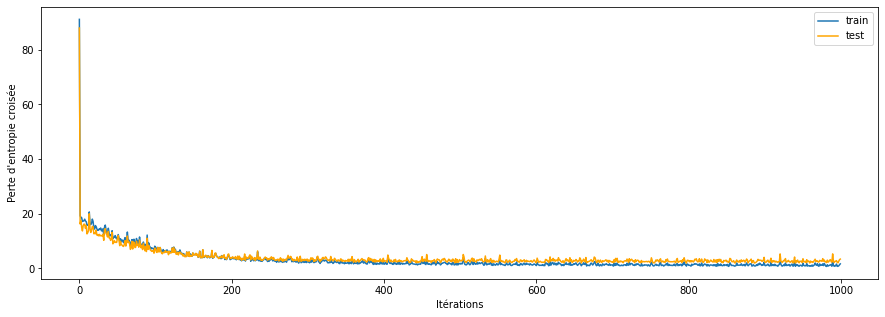

In [22]:
# Ploter la courbe de perte
plt.figure(figsize=(15, 5))
plt.plot(train_pertes, label="train")
plt.plot(test_pertes, color="orange", label="test")
plt.xlabel("Itérations")
plt.ylabel("Perte d'entropie croisée")
plt.legend()
plt.show()

#### Prediction

In [24]:
y_probas = calculer_softmax(X_test, W, b)
y_pred = classes[np.argmax(y_probas, axis=1)]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      HIV1_A       0.57      0.87      0.68        15
      HIV1_B       0.00      0.00      0.00        15
      HIV1_C       0.48      0.93      0.64        15
      HIV1_D       0.80      0.53      0.64        15
      HIV1_F       0.82      0.93      0.87        15
      HIV1_G       0.62      0.67      0.65        15
      HIV1_H       0.70      0.47      0.56        15

    accuracy                           0.63       105
   macro avg       0.57      0.63      0.58       105
weighted avg       0.57      0.63      0.58       105



### 3.2.2. Exemples de modèles discriminatifs


| Outil       | Type de modèle            | Utilisation| Article                                               |
|:------------|:--------------------------|:-----------|:------------------------------------------------------|
|CASTOR-KRFE  | SVM                       |Virus    |https://www.liebertpub.com/doi/full/10.1089/cmb.2018.0239 |
|Kameris      | SVM, Régression logistique|Virus        |  https://doi.org/10.1371/journal.pone.0206409        |
|PhyloPythiaS+| SVM                       |Métagénomique|https://peerj.com/articles/1603/                      |
|VirFinder    | Régression logistique     |Métagénomique|https://doi.org/10.1186/s40168-017-0283-5             |